In [35]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import numpy as np
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import pickle
import time
import pandas as pd
import seaborn as sns

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import cv2

from torchvision.utils import make_grid
import torch.nn.functional as F

In [15]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [16]:

# ==========================================================
# Configuration
# ==========================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 0

g = torch.Generator()
g.manual_seed(42)

# ==========================================================
# Transforms
# ==========================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# ==========================================================
# Datasets and Splits
# ==========================================================
# Load once (without transform)
full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

# Split indices using a fixed seed generator
train_indices, val_indices = random_split(range(len(full_train)), [45000, 5000], generator=g)
test_indices, small_test_indices = random_split(range(len(full_test)), [7500, 2500], generator=g)

# Wrap each subset with its own dataset and transform
train_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=train_transform),
    train_indices.indices
)
val_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=test_transform),
    val_indices.indices
)
test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    test_indices.indices
)
small_test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    small_test_indices.indices
)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))
print("Small test size:", len(small_test_dataset))

# ==========================================================
# Dataloaders
# ==========================================================
def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_dataset, shuffle=True)
val_loader = get_loader(val_dataset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)
small_test_loader = get_loader(small_test_dataset, shuffle=False)


Training set size: 45000
Validation set size: 5000
Test set size: 7500
Small test size: 2500


In [17]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

vgg11_dense = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11_dense.classifier[6] = torch.nn.Linear(4096, 100)
vgg11_dense.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
vgg11_dense.load_state_dict(torch.load('models/vgg11_cifar100_baseline.pt', weights_only=True, map_location=device))
vgg11_dense.to(device)

vgg11_pruned_unstructured = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11_pruned_unstructured.classifier[6] = torch.nn.Linear(4096, 100)
vgg11_pruned_unstructured.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
vgg11_pruned_unstructured.load_state_dict(torch.load('models/vgg11_cifar100_pruned_unstructured.pt', weights_only=True, map_location=device))
vgg11_pruned_unstructured.to(device)

vgg11_pruned_unstructured_finetuned = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11_pruned_unstructured_finetuned.classifier[6] = torch.nn.Linear(4096, 100)
vgg11_pruned_unstructured_finetuned.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
vgg11_pruned_unstructured_finetuned.load_state_dict(torch.load('models/vgg11_cifar100_pruned_unstructured_finetuned.pt', weights_only=True, map_location=device))
vgg11_pruned_unstructured_finetuned.to(device)

vgg11_pruned_unstructured_finetuned_pruned = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11_pruned_unstructured_finetuned_pruned.classifier[6] = torch.nn.Linear(4096, 100)
vgg11_pruned_unstructured_finetuned_pruned.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
vgg11_pruned_unstructured_finetuned_pruned.load_state_dict(torch.load('models/vgg11_cifar100_pruned_unstructured_finetuned_pruned.pt', weights_only=True, map_location=device))
vgg11_pruned_unstructured_finetuned_pruned.to(device)

state_dict = torch.load('models/vgg11_cifar100_pruned_structured_finetuned.pt', map_location='cpu')
for k, v in state_dict.items():
    if 'weight' in k and len(v.shape) == 4:
        print(f"{k}: {v.shape}")
def make_vgg11_pruned():
    cfg = [52, 'M', 101, 'M', 196, 186, 'M', 361, 345, 'M', 330, 512, 'M']

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                       nn.ReLU(inplace=True)]
            in_channels = v
    features = nn.Sequential(*layers)

    # Classifier for CIFAR-100
    classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, 4096),  # adjust if you used adaptive pooling
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 100)
    )

    model = models.vgg.VGG(features, num_classes=100)
    return model

vgg11_pruned_structured = make_vgg11_pruned()
state_dict = torch.load('models/vgg11_cifar100_pruned_structured.pt', map_location=device)
vgg11_pruned_structured.load_state_dict(state_dict)
vgg11_pruned_structured.to(device)

vgg11_pruned_structured_finetuned = make_vgg11_pruned()
state_dict = torch.load('models/vgg11_cifar100_pruned_structured_finetuned.pt', map_location=device)
vgg11_pruned_structured_finetuned.load_state_dict(state_dict)
vgg11_pruned_structured_finetuned.to(device)

print()

features.0.weight: torch.Size([52, 3, 3, 3])
features.3.weight: torch.Size([101, 52, 3, 3])
features.6.weight: torch.Size([196, 101, 3, 3])
features.8.weight: torch.Size([186, 196, 3, 3])
features.11.weight: torch.Size([361, 186, 3, 3])
features.13.weight: torch.Size([345, 361, 3, 3])
features.16.weight: torch.Size([330, 345, 3, 3])
features.18.weight: torch.Size([512, 330, 3, 3])



### Model Sizes

In [18]:
def get_model_size(model: nn.Module, count_nonzero_only=False) -> int:
    total_bits = 0
    for param in model.parameters():
        bits_per_element = param.element_size() * 8  # element_size() gives bytes
        num_elems = param.numel()
        if count_nonzero_only:
            num_elems = (param != 0).sum().item()
        total_bits += num_elems * bits_per_element
    return total_bits

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [19]:
dense_model_size = get_model_size(vgg11_dense)
print(f"\nDense model has size={dense_model_size/MiB:.2f} MiB")

sparse_model_size = get_model_size(vgg11_pruned_unstructured_finetuned_pruned, count_nonzero_only=True)
print(f"Sparse Unstructured model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_structured_model_size = get_model_size(vgg11_pruned_structured_finetuned)
print(f"Sparse Structured model has size={sparse_structured_model_size/MiB:.2f} MiB = {sparse_structured_model_size / dense_model_size * 100:.2f}% of dense model size")


Dense model has size=492.77 MiB
Sparse Unstructured model has size=147.86 MiB = 30.01% of dense model size
Sparse Structured model has size=476.01 MiB = 96.60% of dense model size


### Evaluation

In [20]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [22]:
print("== Baseline ==")
acc = evaluate(vgg11_dense, test_loader, device)
print(f"Accuracy: {acc:.2f}f")

print("\n== Unstructured Pruning ==")
acc = evaluate(vgg11_pruned_unstructured, test_loader, device)
print(f"Pruned Accuracy: {acc:.2f}f")
acc = evaluate(vgg11_pruned_unstructured_finetuned, test_loader, device)
print(f"Pruned Finetuned Accuracy: {acc:.2f}f")
acc = evaluate(vgg11_pruned_unstructured_finetuned_pruned, test_loader, device)
print(f"Pruned Finetuned Pruned Accuracy: {acc:.2f}f")

print("\n== Structured Pruning ==")
acc = evaluate(vgg11_pruned_structured, test_loader, device)
print(f"Pruned Accuracy: {acc:.2f}f")
acc = evaluate(vgg11_pruned_structured_finetuned, test_loader, device)
print(f"Pruned Finetuned Accuracy: {acc:.2f}f")

== Baseline ==
Accuracy: 74.33f

== Unstructured Pruning ==
Pruned Accuracy: 72.73f
Pruned Finetuned Accuracy: 72.64f
Pruned Finetuned Pruned Accuracy: 72.28f

== Structured Pruning ==
Pruned Accuracy: 54.93f
Pruned Finetuned Accuracy: 71.64f


### GradCAM

In [43]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

cifar100_classes = torchvision.datasets.CIFAR100(root='./data', train=False).classes

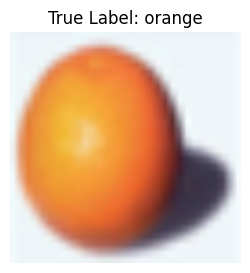

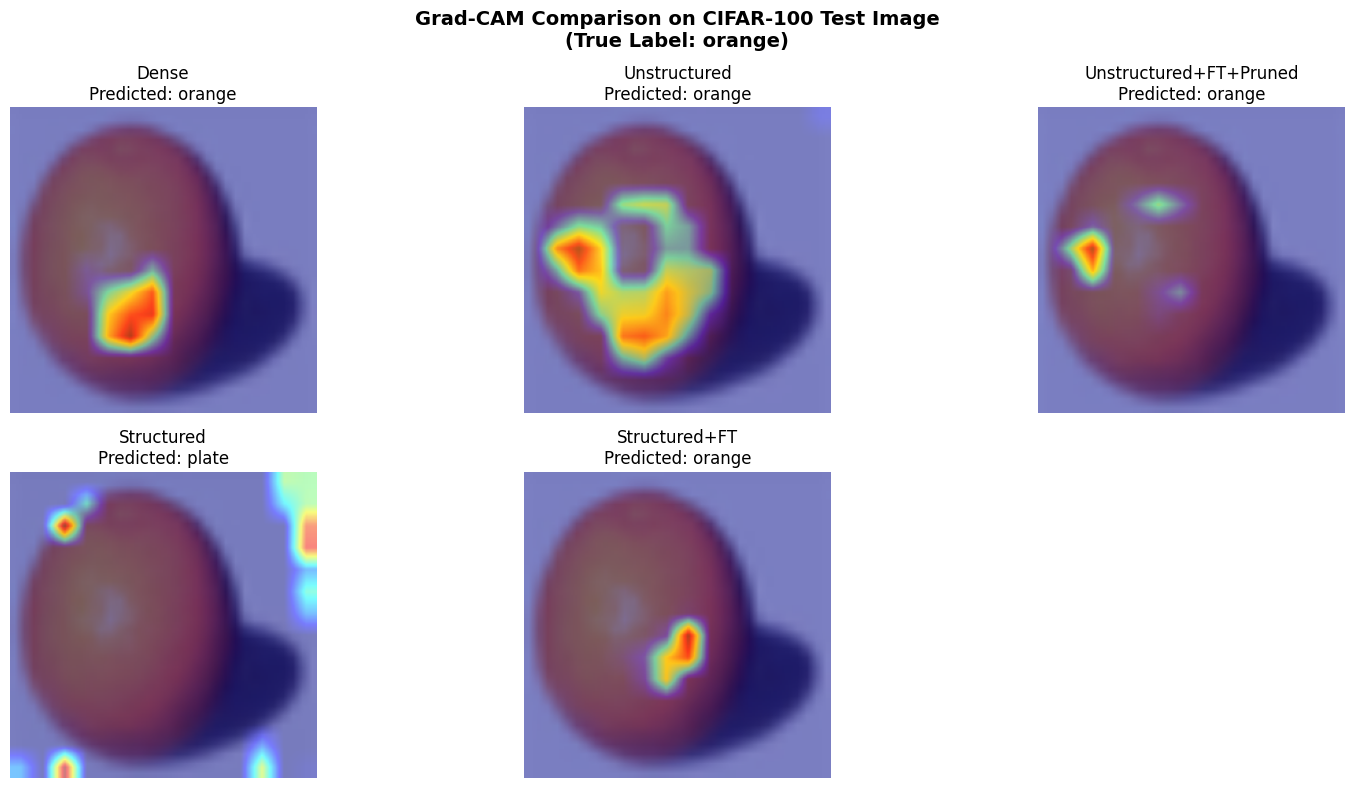

In [114]:
idx = random.randint(0, len(images) - 1)
idx = random.randint(0, len(images) - 1)

input_tensor = images[idx:idx+1]
true_label = labels[idx].item()
true_label_name = cifar100_classes[true_label]

# Denormalize for visualization
def denormalize(tensor):
    mean = torch.tensor(imagenet_mean).view(3, 1, 1)
    std = torch.tensor(imagenet_std).view(3, 1, 1)
    img = tensor.cpu() * std + mean
    return img.clamp(0, 1)

rgb_img = denormalize(images[idx]).permute(1, 2, 0).numpy()

plt.figure(figsize=(3, 3))
plt.imshow(rgb_img)
plt.title(f"True Label: {true_label_name}")
plt.axis("off")
plt.show()

# ==========================================================
# Grad-CAM generation helper
# ==========================================================
def generate_gradcam(model, input_tensor, target_layer_name, device):
    model.eval()
    model.to(device)
    target_layer = dict(model.named_modules())[target_layer_name]

    cam = GradCAM(model=model, target_layers=[target_layer])

    outputs = model(input_tensor.to(device))
    target_class = outputs.argmax(dim=1).item()
    target_name = cifar100_classes[target_class]

    grayscale_cam = cam(input_tensor=input_tensor.to(device),
                        targets=[ClassifierOutputTarget(target_class)])
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(np.float32(rgb_img), grayscale_cam, use_rgb=True)
    return visualization, target_name

# ==========================================================
# Compare across models
# ==========================================================
models_to_visualize = {
    "Dense": vgg11_dense,
    "Unstructured": vgg11_pruned_unstructured,
    "Unstructured+FT+Pruned": vgg11_pruned_unstructured_finetuned_pruned,
    "Structured": vgg11_pruned_structured,
    "Structured+FT": vgg11_pruned_structured_finetuned
}

device = "cuda" if torch.cuda.is_available() else "cpu"
target_layer_name = "features.18"  # last conv layer

plt.figure(figsize=(16, 8))

for i, (name, model) in enumerate(models_to_visualize.items(), 1):
    cam_img, pred_name = generate_gradcam(model, input_tensor, target_layer_name, device)
    plt.subplot(2, 3, i)
    plt.imshow(cam_img)
    plt.title(f"{name}\nPredicted: {pred_name}")
    plt.axis("off")

plt.suptitle(f"Grad-CAM Comparison on CIFAR-100 Test Image\n(True Label: {true_label_name})", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

### Sparsity Analysis

In [25]:
with open('models/structured_pruning_fine_tuned_sparsity_dict_2_6.pkl', 'rb') as f:
    sparsity_fine_tuned_dict_2_6 = pickle.load(f)

with open('models/structured_pruning_fine_tuned_sparsity_dict_7_9.pkl', 'rb') as f:
    sparsity_fine_tuned_dict_7_9 = pickle.load(f)

fine_tuned_dict = copy.deepcopy(sparsity_fine_tuned_dict_2_6)
for spars, acc in sparsity_fine_tuned_dict_7_9.items():
    fine_tuned_dict[spars] = acc

with open('models/structured_pruning_no_tune_sparsity_dict_2_6.pkl', 'rb') as f:
    sparsity_no_tune_dict_2_6 = pickle.load(f)

with open('models/structured_pruning_no_tune_sparsity_dict_7_9.pkl', 'rb') as f:
    sparsity_no_tune_dict_7_9 = pickle.load(f)

no_tune_dict = copy.deepcopy(sparsity_no_tune_dict_2_6)
for spars, acc in sparsity_no_tune_dict_7_9.items():
    no_tune_dict[spars] = acc

In [26]:
print(fine_tuned_dict)

print(no_tune_dict)

{0.2: 72.08, 0.3: 71.46666666666667, 0.4: 70.82666666666667, 0.5: 70.05333333333333, 0.6: 69.05333333333333, 0.7: 67.53333333333333, 0.8: 64.14666666666666, 0.9: 58.53333333333334}
{0.2: 65.70666666666666, 0.3: 54.93333333333334, 0.4: 44.14666666666667, 0.5: 30.05333333333333, 0.6: 16.733333333333334, 0.7: 5.0, 0.8: 1.32, 0.9: 0.9866666666666666}


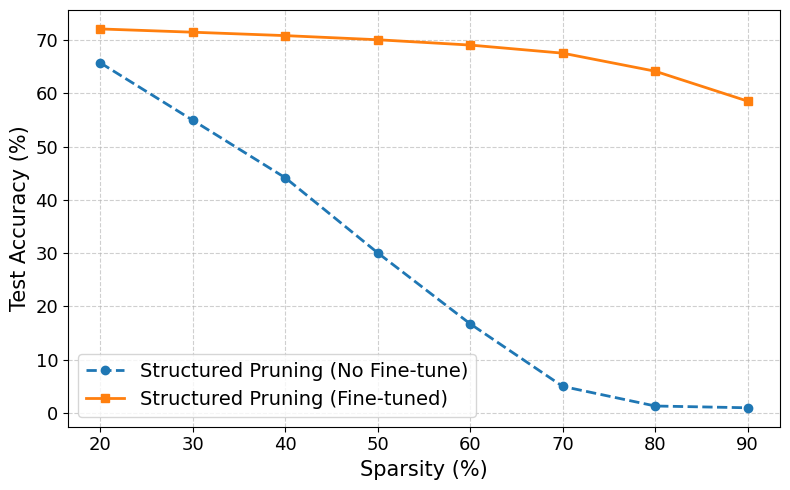

In [123]:
# Extract x (sparsity) and y (accuracy)
x_no_tune = [x * 100 for x in no_tune_dict.keys()]
y_no_tune = list(no_tune_dict.values())

x_tuned = [x * 100 for x in fine_tuned_dict.keys()]
y_tuned = list(fine_tuned_dict.values())

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_no_tune, y_no_tune, 'o--', label='Structured Pruning (No Fine-tune)', linewidth=2)
plt.plot(x_tuned, y_tuned, 's-', label='Structured Pruning (Fine-tuned)', linewidth=2)

# Labels and formatting
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Sparsity (%)", fontsize=15)
plt.ylabel("Test Accuracy (%)", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


### Inference Times

In [30]:
# ==========================================================
# Helper: measure inference time for a model
# ==========================================================
def measure_inference_time(model, device, input_shape=(1, 3, 224, 224), runs=50, warmup=10):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)

    # Warm-up to stabilize timings (esp. for GPU)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)

    # Timed runs
    torch.cuda.synchronize() if device == "cuda" else None
    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(dummy_input)
    torch.cuda.synchronize() if device == "cuda" else None
    end = time.time()

    avg_time = (end - start) / runs
    return avg_time


# ==========================================================
# Load your models (assuming already defined/loaded)
# ==========================================================
models = {
    "vgg11_dense": vgg11_dense,
    "vgg11_pruned_unstructured": vgg11_pruned_unstructured,
    "vgg11_pruned_unstructured_finetuned": vgg11_pruned_unstructured_finetuned,
    "vgg11_pruned_unstructured_finetuned_pruned": vgg11_pruned_unstructured_finetuned_pruned,
    "vgg11_pruned_structured": vgg11_pruned_structured,
    "vgg11_pruned_structured_finetuned": vgg11_pruned_structured_finetuned,
}

# ==========================================================
# Benchmark on both CPU and GPU (if available)
# ==========================================================
results = []

devices = ["cpu"]
if torch.cuda.is_available():
    devices.append("cuda")

for device in devices:
    print(f"\n🔹 Benchmarking on {device.upper()}")
    for name, model in models.items():
        model = model.to(device)
        avg_time = measure_inference_time(model, device)
        results.append({
            "Model": name,
            "Device": device,
            "Avg Inference Time (s)": avg_time,
            "Images/sec": 1 / avg_time
        })
        print(f"{name:45s} → {avg_time*1000:.2f} ms / image")

# ==========================================================
# Summarize in table
# ==========================================================
df = pd.DataFrame(results)
df_pivot = df.pivot(index="Model", columns="Device", values="Avg Inference Time (s)")
print("\n=== Inference Time Comparison (s) ===")
print(df_pivot.round(5))

# Optionally save results
df.to_csv("inference_times_vgg11.csv", index=False)



🔹 Benchmarking on CPU
vgg11_dense                                   → 73.15 ms / image
vgg11_pruned_unstructured                     → 74.21 ms / image
vgg11_pruned_unstructured_finetuned           → 73.06 ms / image
vgg11_pruned_unstructured_finetuned_pruned    → 73.33 ms / image
vgg11_pruned_structured                       → 54.32 ms / image
vgg11_pruned_structured_finetuned             → 57.62 ms / image

🔹 Benchmarking on CUDA
vgg11_dense                                   → 5.94 ms / image
vgg11_pruned_unstructured                     → 5.62 ms / image
vgg11_pruned_unstructured_finetuned           → 5.59 ms / image
vgg11_pruned_unstructured_finetuned_pruned    → 5.60 ms / image
vgg11_pruned_structured                       → 4.23 ms / image
vgg11_pruned_structured_finetuned             → 4.20 ms / image

=== Inference Time Comparison (s) ===
Device                                          cpu     cuda
Model                                                       
vgg11_dense       

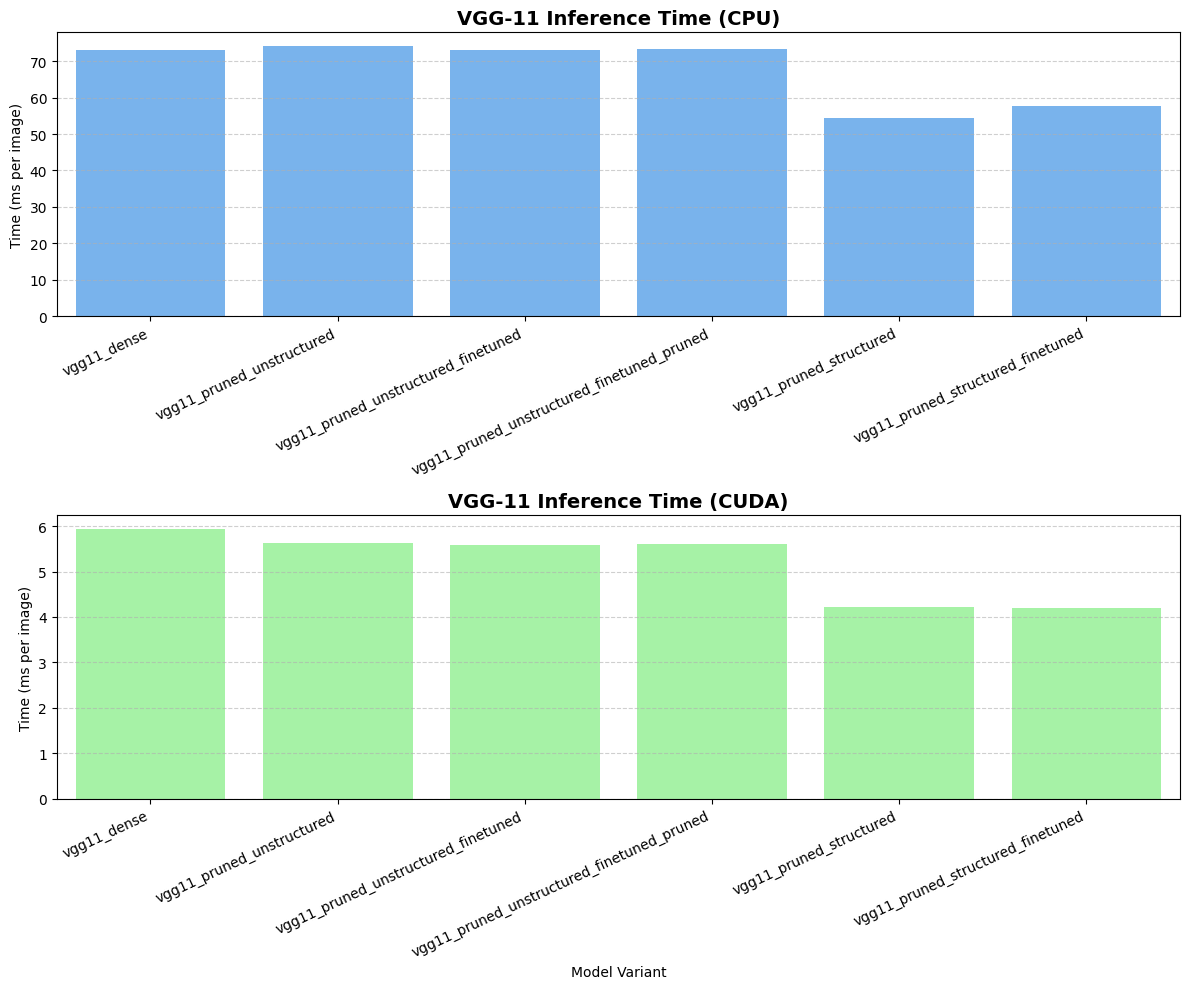

In [33]:

# Convert to ms per image
df["ms_per_image"] = df["Avg Inference Time (s)"] * 1000

# Separate CPU and CUDA results
df_cpu = df[df["Device"] == "cpu"]
df_cuda = df[df["Device"] == "cuda"]

# Set up figure
plt.figure(figsize=(12, 10))

# ===== CPU Plot =====
plt.subplot(2, 1, 1)
sns.barplot(
    data=df_cpu,
    x="Model",
    y="ms_per_image",
    color="#66b3ff"
)
plt.title("VGG-11 Inference Time (CPU)", fontsize=14, weight="bold")
plt.ylabel("Time (ms per image)")
plt.xlabel("")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# ===== CUDA Plot =====
plt.subplot(2, 1, 2)
sns.barplot(
    data=df_cuda,
    x="Model",
    y="ms_per_image",
    color="#99ff99"
)
plt.title("VGG-11 Inference Time (CUDA)", fontsize=14, weight="bold")
plt.ylabel("Time (ms per image)")
plt.xlabel("Model Variant")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Pruning Sensitivity

#### Unstructured

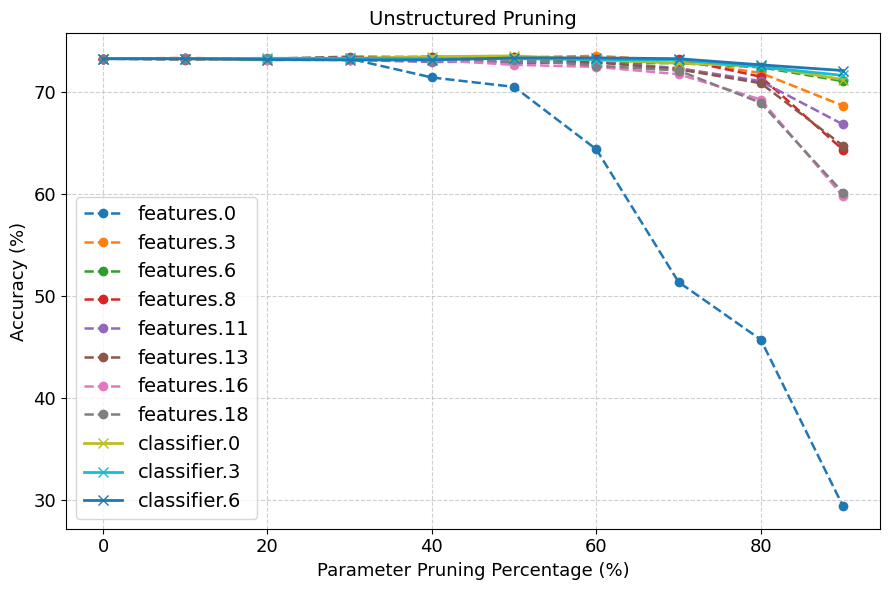

In [166]:
with open('models/sensitivity_dict_unstructured.pkl', 'rb') as f:
    sensitivity_dict_unstructured = pickle.load(f)

sensitivity_dict_unstructured_copy = copy.deepcopy(sensitivity_dict_unstructured)
for (name, _) in sensitivity_dict_unstructured_copy.keys():
    sensitivity_dict_unstructured[(name, 0)] = 73.28

# print(sensitivity_dict_unstructured)

conv_data = {k: v for k, v in sensitivity_dict_unstructured.items() if 'features' in k[0]}
clf_data  = {k: v for k, v in sensitivity_dict_unstructured.items() if 'classifier' in k[0]}

# Group by layer
def group_by_layer(data):
    layers = {}
    for (layer, prune_pct), acc in data.items():
        layers.setdefault(layer, []).append((prune_pct, acc))
    for layer in layers:
        layers[layer].sort()
    return layers

conv_layers = group_by_layer(conv_data)
clf_layers  = group_by_layer(clf_data)

# Plot everything on one figure
plt.figure(figsize=(9, 6))

# Plot Conv layers with circles
for layer, vals in conv_layers.items():
    xs, ys = zip(*vals)
    plt.plot(xs, ys, marker='o', markersize=6 , linestyle='--', linewidth=1.8, label=layer)

# Plot Classifier layers with crosses
for layer, vals in clf_layers.items():
    xs, ys = zip(*vals)
    plt.plot(xs, ys, marker='x',markersize=7, linestyle='-', linewidth=2, label=layer)

plt.title("Unstructured Pruning", fontsize=14)
plt.xlabel("Parameter Pruning Percentage (%)", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


#### Structured

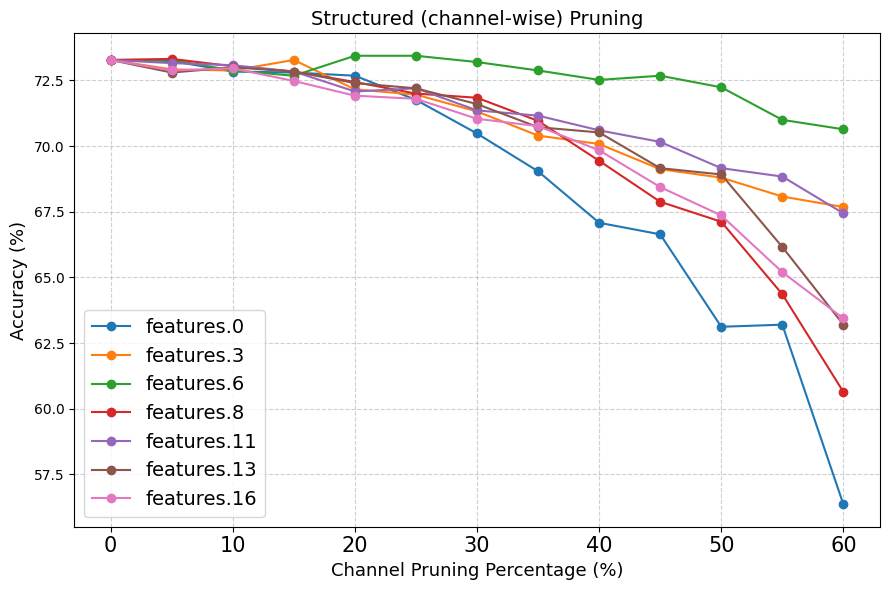

In [167]:
with open('models/sensitivity_dict_structured.pkl', 'rb') as f:
    sensitivity_dict_structured = pickle.load(f)

sensitivity_dict_structured_copy = copy.deepcopy(sensitivity_dict_structured)
for (name, _) in sensitivity_dict_structured_copy.keys():
    sensitivity_dict_structured[(name, 0)] = 73.28

conv_data = {k: v for k, v in sensitivity_dict_structured.items() if 'features' in k[0]}

# Group by layer
def group_by_layer(data):
    layers = {}
    for (layer, prune_pct), acc in data.items():
        layers.setdefault(layer, []).append((prune_pct, acc))
    for layer in layers:
        layers[layer].sort()
    return layers

conv_layers = group_by_layer(conv_data)

# Plot structured pruning sensitivity
plt.figure(figsize=(9, 6))
for layer, vals in conv_layers.items():
    xs, ys = zip(*vals)
    plt.plot(xs, ys, marker='o', linestyle='-', label=layer)

plt.title("Structured (channel-wise) Pruning", fontsize=14)
plt.xlabel("Channel Pruning Percentage (%)", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)
plt.xticks(fontsize=13)
plt.xticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
